In [1]:
import argparse
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

In [2]:
def MLKF_1dof(m1, l1, k1, f1):
    """Return mass, damping, stiffness & force matrices for 1DOF system"""
    M = np.array([[m1]])
    L = np.array([[l1]])
    K = np.array([[k1]])
    F = np.array([f1])
    return M, L, K, F

In [3]:
def MLKF_Ndof(m1, l1, k1, f1, m2, l2, k2):
    """Return mass, damping, stiffness & force matrices for NDOF system"""
    M = np.zeros((len(m2) + 1, len(m2) + 1))
    M[0][0] = -m1
    for i, m in enumerate(m2):
        M[1 + i][1 + i] = m
        M[1 + i][0] = m
    L = np.zeros((len(m2) + 1, len(m2) + 1))
    L[0][0] = -l1
    for i, l in enumerate(l2):
        L[1 + i][1 + i] = l
        L[0][1 + i] = l
    K = np.zeros((len(m2) + 1, len(m2) + 1))
    K[0][0] = -k1
    for i, k in enumerate(k2):
        K[1 + i][1 + i] = k
        K[0][1 + i] = k
    F = np.zeros((len(m2) + 1,))
    F[0] = f1
    return M, L, K, F

In [4]:
def MLKF_2dof(m1, l1, k1, f1, m2, l2, k2, f2):
    """Return mass, damping, stiffness & force matrices for 2DOF system"""
    M = np.array([[m1, 0], [0, m2]])
    L = np.array([[l1 + l2, -l2], [-l2, l2]])
    K = np.array([[k1 + k2, -k2], [-k2, k2]])
    F = np.array([f1, f2])
    return M, L, K, F

In [5]:
def freq_response(w_list, M, L, K, F):
    """Return complex frequency response of system"""
    return np.array([np.linalg.solve(-w * w * M + 1j * w * L + K, F) for w in w_list])

In [6]:
def time_response(t_list, M, L, K, F):
    """Return time response of system"""
    mm = M.diagonal()
    def slope(t, y):
        xv = y.reshape((2, -1))
        a = (F - L @ xv[1] - K @ xv[0]) / mm
        s = np.concatenate((xv[1], a))
        return s
    solution = scipy.integrate.solve_ivp(
        fun=slope,
        t_span=(t_list[0], t_list[-1]),
        y0=np.zeros(len(mm) * 2),
        method="Radau",
        t_eval=t_list,
    )
    return solution.y[0 : len(mm), :].T

In [7]:
def last_nonzero(arr, axis, invalid_val=-1):
    """Return index of last non-zero element of an array"""
    mask = arr != 0
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

In [8]:
def plot(hz, sec, M, L, K, F):
    """Plot frequency and time domain responses"""

    # Generate response data
    f_response = np.abs(freq_response(hz * 2 * np.pi, M, L, K, F))
    t_response = time_response(sec, M, L, K, F)
    t_response[:, 1:] += t_response[:, 0:1]

    # Determine suitable legends
    f_legends = (
        "m{} peak {:.4g} metre at {:.4g} Hz".format(i, f_response[m][i], hz[m])
        for i, m in enumerate(np.argmax(f_response, axis=0))
    )
    equilib = np.abs(freq_response([0], M, L, K, F))[0]  # Zero Hz
    toobig = abs(100 * (t_response - equilib) / equilib) >= 2
    lastbig = last_nonzero(toobig, axis=0, invalid_val=len(sec) - 1)
    t_legends = (
        "m{} settled to 2% beyond {:.4g} sec".format(i, sec[lastbig[i]])
        for i, _ in enumerate(t_response.T)
    )

    # Create plot
    fig, ax = plt.subplots(2, 1, figsize=(11.0, 7.7))
    ax[0].set_title("Frequency domain response")
    ax[0].set_xlabel("Frequency/hertz")
    ax[0].set_ylabel("Amplitude/metre")
    ax[0].legend(ax[0].plot(hz, f_response), f_legends)
    ax[1].set_title("Time domain response")
    ax[1].set_xlabel("Time/second")
    ax[1].set_ylabel("Displacement/metre")
    ax[1].legend(ax[1].plot(sec, t_response), t_legends)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_28030/522541018.py:15: RuntimeWarning: divide by zero encountered in divide
  toobig = abs(100 * (t_response - equilib) / equilib) >= 2
/tmp/ipykernel_28030/522541018.py:15: RuntimeWarning: invalid value encountered in divide
  toobig = abs(100 * (t_response - equilib) / equilib) >= 2


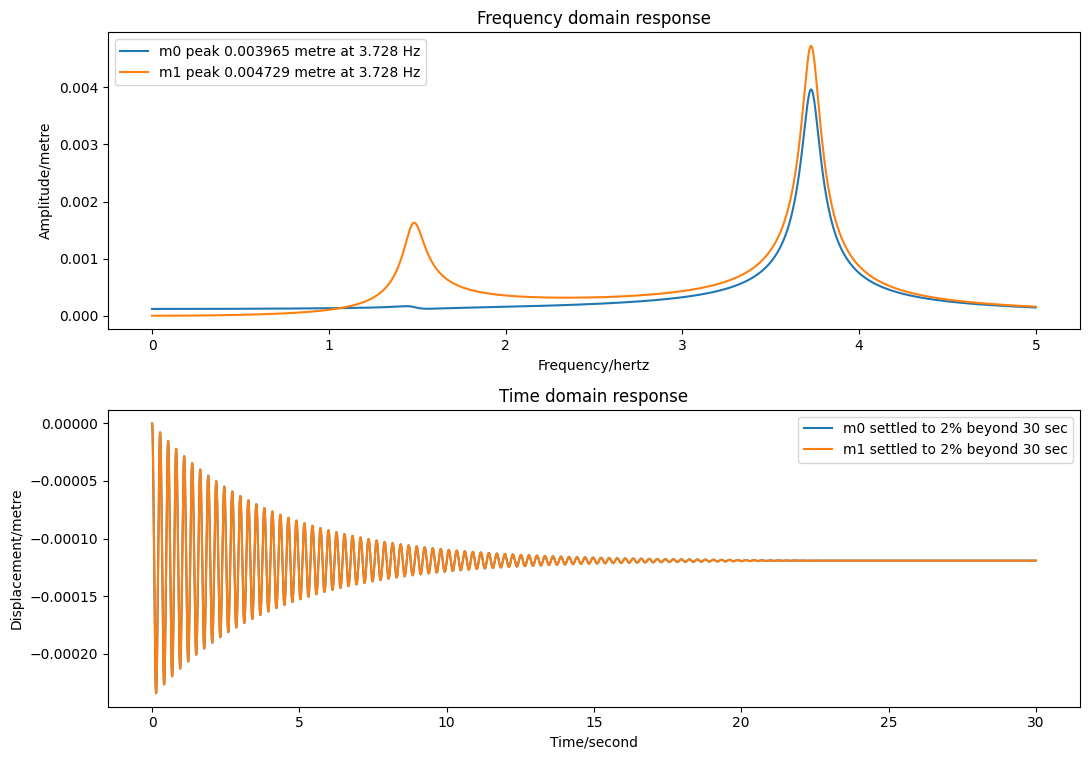

In [9]:
test = True
"""Main program"""
hz = [0, 5]
sec = 30
m1 = 3.94
l1 = 1.98
k1 = 2100
f1 = 0.25
if test:
    m2 = [0.6]
    l2 = [0.5]
    k2 = [53.4]
else:
    m2 = [0.6, 0.6, 0.6, 0.6, 0.6]
    l2 = [0.5, 0.5, 0.5, 0.5, 0.5]
    k2 = [53.4, 53.4, 53.4, 53.4, 53.4]
M, L, K, F = MLKF_Ndof(m1, l1, k1, f1, m2, l2, k2)
# Generate frequency and time arrays
hz = np.linspace(hz[0], hz[1], 10001)
sec = np.linspace(0, sec, 10001)

# Plot results
plot(hz, sec, M, L, K, F)